<a href="https://colab.research.google.com/github/austiezr/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] If you haven't completed assignment #1, please do so first.
- [x] Continue to clean and explore your data. Make exploratory visualizations.
- [x] Fit a model. Does it beat your baseline? 
- [x] Try xgboost.
- [x] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
%%capture

!pip3 install category_encoders
!pip3 install pandas-profiling
!pip3 install xgboost
import pandas_profiling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression, f_classif
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, DMatrix
from sys import maxsize

## Load Data

In [0]:
df = pd.read_csv('/Users/austie/Downloads/student/student-mat.csv', sep=';')
df1 = pd.read_csv('/Users/austie/Downloads/student/student-por.csv', sep=';')
df = df.append(df1, ignore_index=True)

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Wrangle Data / Create Target / Split

In [0]:
%%capture

df['famsize'] = df['famsize'].map({'GT3': 1, 'LE3':0})
df['address'] = df['address'].map({'U':1, 'R':0})
df['Pstatus'] = df['Pstatus'].map({'A': 0, 'T':1})
for col in ['schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'internet', 'romantic']:
  df[col] = df[col].map({'yes':1, 'no':0})

for col in ['G1', 'G2', 'G3']:
  df[col] = df[col].replace({0: np.NaN})

dfmean = df[['G1', 'G2', 'G3']]
dfmean['Mean'] = dfmean.mean(axis=1)
df['Mean'] = dfmean['Mean']
df['Pass/Fail'] = df['G3']>=10

df['Improved'] = (df['G3']-df['Mean'])>0

df = df.drop(columns=['school'])

training, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=33)
train, val = train_test_split(training, train_size=0.80, test_size=0.20, random_state=33)

In [0]:
target = 'Improved'
features = train.drop(columns=[target, 'G1', 'G2', 'Mean']).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
X_training = training[features]
y_training = training[target]

In [0]:
encoder = OrdinalEncoder()
X_training_encoded = encoder.fit_transform(X=X_training)
X_test_encoded = encoder.fit_transform(X=X_test)

In [7]:
X_training_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 427 to 391
Data columns (total 31 columns):
sex           835 non-null int64
age           835 non-null int64
address       835 non-null int64
famsize       835 non-null int64
Pstatus       835 non-null int64
Medu          835 non-null int64
Fedu          835 non-null int64
Mjob          835 non-null int64
Fjob          835 non-null int64
reason        835 non-null int64
guardian      835 non-null int64
traveltime    835 non-null int64
studytime     835 non-null int64
failures      835 non-null int64
schoolsup     835 non-null int64
famsup        835 non-null int64
paid          835 non-null int64
activities    835 non-null int64
nursery       835 non-null int64
higher        835 non-null int64
internet      835 non-null int64
romantic      835 non-null int64
famrel        835 non-null int64
freetime      835 non-null int64
goout         835 non-null int64
Dalc          835 non-null int64
Walc          835 non-null int64
he

## Majority Class Baseline

In [8]:
df[target].value_counts(normalize=True)

True     0.536398
False    0.463602
Name: Improved, dtype: float64

## Fast First Model

Training Accuracy: 0.6526946107784432

Test Accuracy: 0.6507177033492823


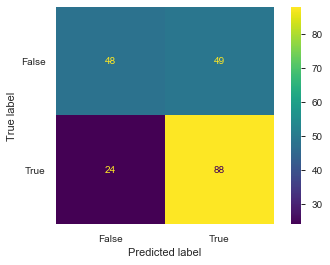

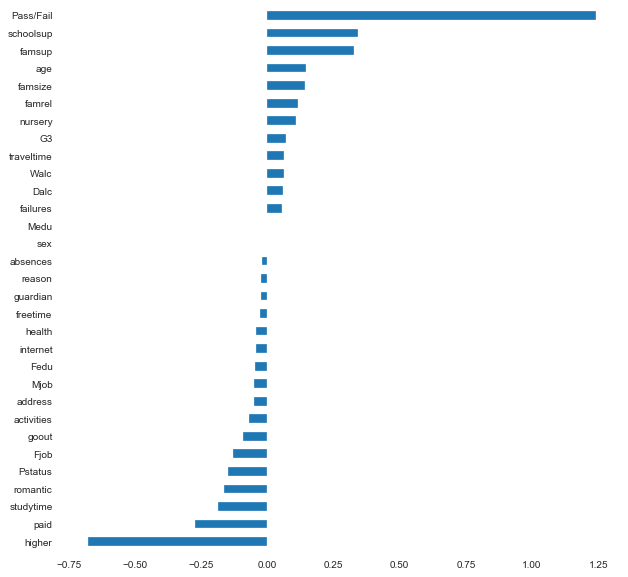

In [9]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegressionCV(n_jobs=-1,
                         random_state=33)
    )


pipe.fit(X_training, y_training)

print(f'Training Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test)

encoder = pipe.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_training).columns
coefficients = pd.Series(pipe.named_steps.logisticregressioncv.coef_[0][:], 
                         encoded_columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

## Iterated Model

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   31.1s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   32.5s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   33.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.4s finished


{'logisticregressioncv__Cs': 74, 'logisticregressioncv__cv': 9, 'logisticregressioncv__refit': False, 'logisticregressioncv__solver': 'sag', 'simpleimputer__strategy': 'most_frequent'}

Train Accuracy: 0.6407185628742516

Test Accuracy: 0.6698564593301436


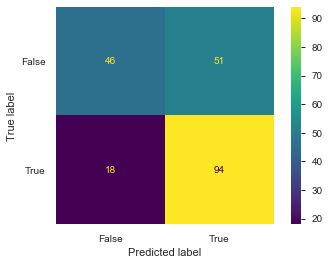

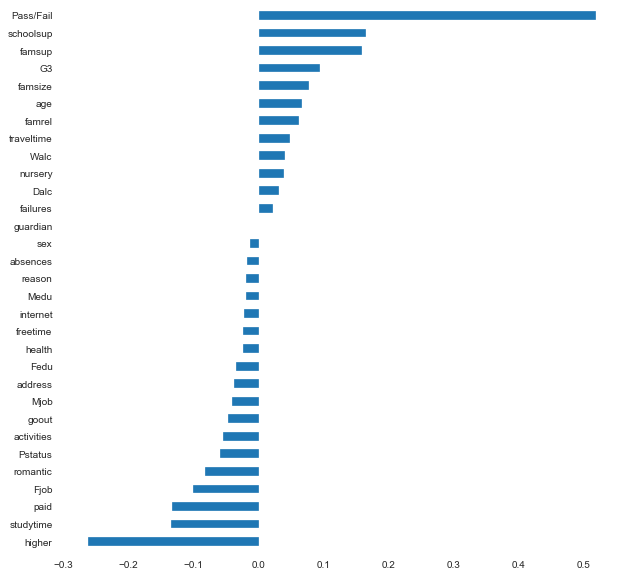

In [25]:
pipe = make_pipeline(
    # TargetEncoder(),
    # IterativeImputer(random_state=33),
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegressionCV(n_jobs=-1,
                         random_state=33,
                         max_iter=10000)
)

param_distributions = {
    # 'targetencoder__min_samples_leaf': randint(1, 101),
    # 'iterativeimputer__initial_strategy': ['mean', 'median', 
    #                                        'most_frequent'],
    # 'iterativeimputer__sample_posterior':[True, False],
    # 'iterativeimputer__max_iter': randint(1, 1001),
    # 'iterativeimputer__imputation_order': ['ascending', 'descending', 
    #                                        'roman', 'arabic', 'random'],
    'simpleimputer__strategy': ['mean', 'median',
                                'most_frequent'],
    'logisticregressioncv__Cs': randint(1, 101),
    'logisticregressioncv__cv': randint(2,11),
    'logisticregressioncv__solver': ['newton-cg', 'lbfgs', 
                                     'liblinear', 'sag', 'saga'],
    'logisticregressioncv__refit': [True, False]
}

search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_training, y_training)

pipe = search.best_estimator_

print(f'{search.best_params_}\n')

print(f'Train Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test)

encoder = pipe.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_training).columns
coefficients = pd.Series(pipe.named_steps.logisticregressioncv.coef_[0][:], 
                         encoded_columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

Train Accuracy: 0.792814371257485

Test Accuracy: 0.6698564593301436


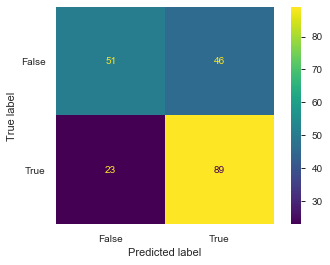

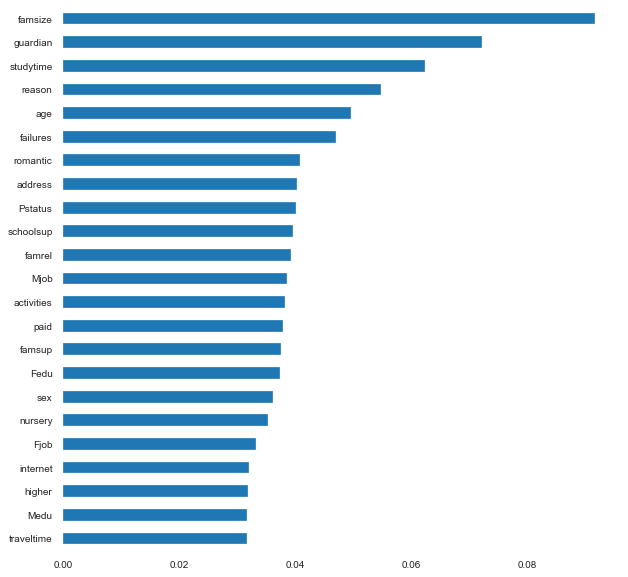

In [10]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    PCA(n_components=27),
    SelectKBest(k=23),
    XGBClassifier(base_score=.5, 
                  booster='gbtree', 
                  objective='binary:hinge', 
                  random_state=33)
)


pipe.fit(X_training, y_training)

print(f'Train Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test)


encoded_columns = X_training_encoded.columns

coefficients = pd.Series(pipe.named_steps.xgbclassifier.feature_importances_[:]
                         [:pipe.named_steps.selectkbest.k], 
                         encoded_columns[:pipe.named_steps.selectkbest.k])
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

Train Accuracy: 0.6383233532934132

Test Accuracy: 0.7033492822966507


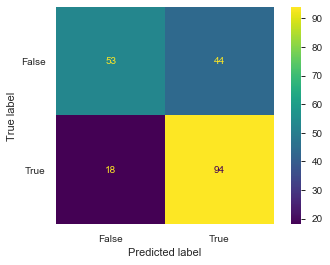

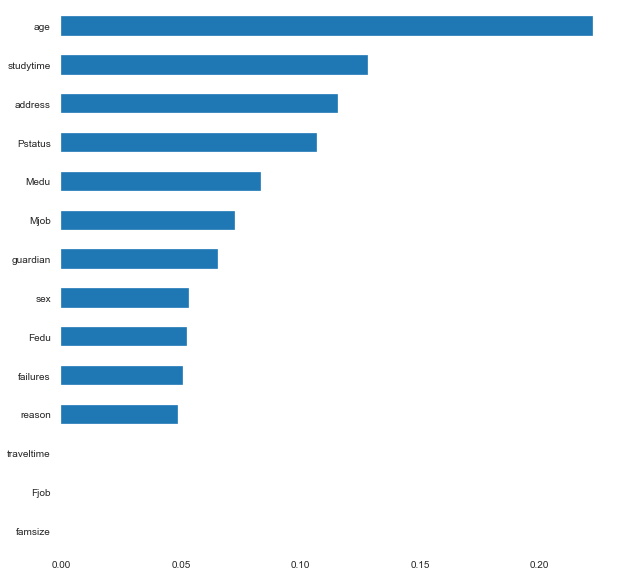

In [9]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='most_frequent'),
    PCA(26),
    SelectKBest(k=14),
    XGBClassifier(alpha=0.40790854859004644, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.45456023198889695, gamma=2,
              learning_rate=0.6553237377561046, max_delta_step=0, max_depth=28,
              min_child_weight=76, missing=None, n_estimators=12, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
)

pipe.fit(X_training, y_training)

print(f'Train Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test_encoded, y_true=y_test)


encoded_columns = X_training_encoded.columns

coefficients = pd.Series(pipe.named_steps.xgbclassifier.feature_importances_[:]
                         [:pipe.named_steps.selectkbest.k], 
                         encoded_columns[:pipe.named_steps.selectkbest.k])
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

In [12]:
eval_set = [(X_training_encoded, y_training),
            (X_test_encoded, y_test)]

model = pipe.named_steps.xgbclassifier
    


model.fit(X_training_encoded, y_training,
         eval_set=eval_set,
         eval_metric='error',
         early_stopping_rounds=30)

model.score(X_test_encoded, y_test)

[0]	validation_0-error:0.413174	validation_1-error:0.334928
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.398802	validation_1-error:0.315789
[2]	validation_0-error:0.40479	validation_1-error:0.358852
[3]	validation_0-error:0.396407	validation_1-error:0.339713
[4]	validation_0-error:0.37485	validation_1-error:0.330144
[5]	validation_0-error:0.382036	validation_1-error:0.325359
[6]	validation_0-error:0.379641	validation_1-error:0.330144
[7]	validation_0-error:0.380838	validation_1-error:0.320574
[8]	validation_0-error:0.379641	validation_1-error:0.330144
[9]	validation_0-error:0.380838	validation_1-error:0.320574
[10]	validation_0-error:0.379641	validation_1-error:0.330144
[11]	validation_0-error:0.380838	validation_1-error:0.311005


0.6889952153110048

In [0]:
%%capture

!pip3 install eli5
from eli5.sklearn.permutation_importance import PermutationImportance

In [61]:
model=(XGBClassifier(alpha=0.40790854859004644, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.45456023198889695, gamma=2,
              learning_rate=0.6553237377561046, max_delta_step=0, max_depth=28,
              min_child_weight=76, missing=None, n_estimators=12, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1))


transformers = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='most_frequent'),
        PCA(26),
        SelectKBest(k=14)
)

X_training_transformed = transformers.fit_transform(X=X_training, y=y_training)
X_test_transformed = transformers.transform(X_test)

model.fit(X_training_transformed, y_training)

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=33
)

permuter.fit(X_test_transformed, y_test)

feature_names = X_test.columns.tolist()
importances = pd.Series(permuter.feature_importances_, 
                        feature_names[:transformers.named_steps.selectkbest.k]).sort_values()
print((importances[importances>0]))
print((importances[importances<0]))

sex         0.001914
failures    0.003828
Medu        0.003828
guardian    0.007656
address     0.027751
age         0.111005
dtype: float64
traveltime   -0.005742
Mjob         -0.002871
Pstatus      -0.000957
dtype: float64


In [0]:
# pipe = make_pipeline(
#     SimpleImputer(),
#     StandardScaler(),
#     PCA(),
#     XGBClassifier(n_jobs=-1,
#                   random_state=33)
# )

# param_distributions = {
#     'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
#     'pca__n_components': randint(1, len(X_training.columns)+1),
#     'xgbclassifier__max_depth': randint(1, 200),
#     'xgbclassifier__booster': ['gbtree', 'gblinear'],
#     'xgbclassifier__objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
#     'xgbclassifier__lambda': randint(1, 10),
#     'xgbclassifier__alpha': uniform(0, 2),
#     'xgbclassifier__gamma': randint(1, 100),
#     'xgbclassifier__min_child_weight': randint(1, 100),
#     'xgbclassifier__eta': uniform(0, 1),
#     'xgbclassifier__n_estimators': randint(1, 1000),
#     'xgbclassifier__learning_rate': uniform(0, 1)
# }

# search = RandomizedSearchCV(
#     pipe, 
#     param_distributions=param_distributions, 
#     n_iter=10000, 
#     cv=10, 
#     scoring='accuracy', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_training_encoded, y_training)

# pipe = search.best_estimator_

# print(f'{search.best_params_}\n')

# print(f'Train Accuracy: {pipe.score(X_training_encoded, y_training)}\n')
# print(f'Test Accuracy: {pipe.score(X_test_encoded, y_test)}')

# plot_confusion_matrix(estimator=pipe, X=X_test_encoded, y_true=y_test)


# encoded_columns = X_training_encoded.columns

# try:
#   importances = pd.Series(pipe.named_steps.xgbclassifier.feature_importances_[0][:pipe.named_steps.pca.n_components], 
#                          encoded_columns[:pipe.named_steps.pca.n_components])
#   plt.figure(figsize=(10,10))
#   importances.sort_values().plot.barh();
# except:
#   coefficients = pd.Series(pipe.named_steps.xgbclassifier.coef_[:][:pipe.named_steps.pca.n_components], 
#                          encoded_columns[:pipe.named_steps.pca.n_components])
#   plt.figure(figsize=(10,10))
#   coefficients.sort_values().plot.barh();

In [0]:
# pipe = make_pipeline(
#     TargetEncoder(),
#     SimpleImputer(strategy='most_frequent'),
#     StandardScaler(),
#     PCA(n_components=27),
#     SelectKBest(k=23),
#     XGBClassifier(base_score=.5, 
#                   booster='gbtree', 
#                   objective='binary:hinge', 
#                   random_state=33)
# )

# param_distributions = {
#     'pca__n_components': randint(1, len(X_training.columns)+1),
#     'pca__whiten': [True, False],
#     'selectkbest__k': randint(1, len(X_training.columns)+1),
#     'xgbclassifier__max_depth': randint(1, 200),
#     'xgbclassifier__objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
#     'xgbclassifier__lambda': randint(1, 10),
#     'xgbclassifier__alpha': uniform(0, 2),
#     'xgbclassifier__gamma': randint(1, 100),
#     'xgbclassifier__min_child_weight': randint(1, 100),
#     'xgbclassifier__eta': uniform(0, 1),
#     'xgbclassifier__n_estimators': randint(1, 1000),
#     'xgbclassifier__learning_rate': uniform(0, 1)
# }

# search = RandomizedSearchCV(
#     pipe, 
#     param_distributions=param_distributions, 
#     n_iter=1000, 
#     cv=10, 
#     scoring='accuracy', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_training_encoded, y_training)

# pipe = search.best_estimator_

# print(f'{search.best_params_}\n')

# print(f'Train Accuracy: {pipe.score(X_training_encoded, y_training)}\n')
# print(f'Test Accuracy: {pipe.score(X_test_encoded, y_test)}')

# plot_confusion_matrix(estimator=pipe, X=X_test_encoded, y_true=y_test)


# encoded_columns = X_training_encoded.columns

# coefficients = pd.Series(pipe.named_steps.xgbclassifier.feature_importances_[:]
#                          [:pipe.named_steps.selectkbest.k], 
#                          encoded_columns[:pipe.named_steps.selectkbest.k])
# plt.figure(figsize=(10,10))
# coefficients.sort_values().plot.barh();